Problem 1
=========

0th epoch starting.
1th epoch starting.ing batch #499 reconstruction loss: 0.032894
2th epoch starting.ing batch #499 reconstruction loss: 0.022606
3th epoch starting.ing batch #499 reconstruction loss: 0.021387
4th epoch starting.ing batch #499 reconstruction loss: 0.016884
5th epoch starting.ing batch #499 reconstruction loss: 0.015085
6th epoch starting.ing batch #499 reconstruction loss: 0.011744
7th epoch starting.ing batch #499 reconstruction loss: 0.012982
8th epoch starting.ing batch #499 reconstruction loss: 0.012659
9th epoch starting.ing batch #499 reconstruction loss: 0.011701
Time ellapsed in training is: 20.00357484817505n loss: 0.010218
threshold:  23.670562831825087
0.009
0.0286


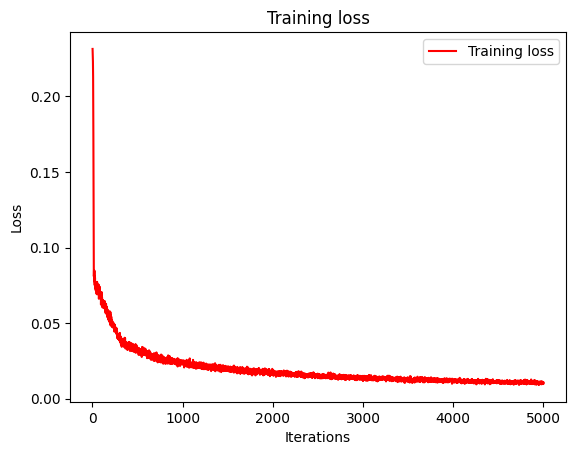

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

lr = 0.001
batch_size = 100
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

'''
Step 1:
'''

# MNIST dataset
dataset = datasets.MNIST(root='./mnist_data/',
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [50000, 10000])

test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False, 
                              transform=transforms.ToTensor())

# KMNIST dataset, only need test dataset
anomaly_dataset = datasets.KMNIST(root='./kmnist_data/',
                              train=False, 
                              transform=transforms.ToTensor(),
                              download=True)

# print(len(train_dataset))  # 50000
# print(len(validation_dataset))  # 10000
# print(len(test_dataset))  # 10000
# print(len(anomaly_dataset))  # 10000

'''
Step 2: AutoEncoder
'''
# Define Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        z = F.relu(self.fc3(x))
        return z

# Define Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 784)
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        x = F.sigmoid(self.fc3(z))  # to make output's pixels are 0~1
        x = x.view(x.size(0), 1, 28, 28) 
        return x
    
'''
Step 3: Instantiate model & define loss and optimizer
'''
enc = Encoder().to(device)
dec = Decoder().to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr)


'''
Step 4: Training
'''
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


train_loss_list = []

import time
start = time.time()
for epoch in range(epochs) :
    print("{}th epoch starting.".format(epoch))
    enc.train()
    dec.train()
    for batch, (images, _) in enumerate(train_loader) :
        images = images.to(device)
        z = enc(images)
        reconstructed_images = dec(z)
        
        optimizer.zero_grad()
        train_loss = loss_function(images, reconstructed_images)
        train_loss.backward()
        train_loss_list.append(train_loss.item())

        optimizer.step()

        print(f"[Epoch {epoch:3d}] Processing batch #{batch:3d} reconstruction loss: {train_loss.item():.6f}", end='\r')
end = time.time()
print("Time ellapsed in training is: {}".format(end - start))

# plotting train loss
plt.plot(range(1,len(train_loss_list)+1), train_loss_list, 'r', label='Training loss')
plt.title('Training loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')

enc.eval()
dec.eval()

'''
Step 5: Calculate standard deviation by using validation set
'''
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size)

def score(gt_image, recon_image):
    return (torch.norm(gt_image - recon_image,p=2).item())**2
    # return nn.MSELoss()(gt_image,recon_image).item()

score_lst = []
for images, _ in validation_loader:
    for image in images :
        score_lst.append(score(image, dec(enc(image))))

mean = np.mean(score_lst)
std = np.std(score_lst)

threshold = mean + 3 * std
print("threshold: ", threshold)


'''
Step 6: Anomaly detection (mnist)
'''
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

mis_classified = 0
for images, _ in test_loader:
    for image in images : 
        if score(image, dec(enc(image))) > threshold :
            mis_classified +=1
print(mis_classified/len(test_dataset))


'''
Step 7: Anomaly detection (kmnist)
'''
anomaly_loader = torch.utils.data.DataLoader(dataset=anomaly_dataset, batch_size=batch_size)

mis_classified = 0
for images, _ in anomaly_loader:
    for image in images:
        if score(image,dec(enc(image))) < threshold :
            mis_classified +=1
print(mis_classified/len(anomaly_dataset))


Problem 2
=========

In [29]:
import torch
import torch.utils.data as data 
import torch.nn as nn
from torch.distributions.normal import Normal 
from torch.distributions.uniform import Uniform
import numpy as np
import matplotlib.pyplot as plt


epochs = 1000
learning_rate = 1e-3
batch_size = 128
n_components= 5 # the number of kernel
target_distribution = Normal(0,1)

####################################
# STEP 1: Implement 1-d Flow model #
# Model is misture of Gaussian CDFs
#
####################################
class Flow1d(nn.Module):
    def __init__(self, n_components):
        super(Flow1d, self).__init__()
        self.mus = nn.Parameter(torch.randn(n_components), requires_grad=True)
        self.log_sigmas = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.weight_logits = nn.Parameter(torch.ones(n_components), requires_grad=True)

    def forward(self, x):
        x = x.view(-1,1)
        weights = torch.exp(self.weight_logits).view(1,-1)
        distribution = Normal(self.mus, self.log_sigmas.exp())
        z = ((distribution.cdf(x)-0.5) * weights).sum(dim=1)
        dz_by_dx = (distribution.log_prob(x).exp() * weights).sum(dim=1)
        return z, dz_by_dx
    
################################################
# STEP 2: Create Dataset and Create Dataloader #
################################################ 

def mixture_of_gaussians(num, mu_var=(-1,0.25, 0.2,0.25, 1.5,0.25)):
    n = num // 3
    m1,s1,m2,s2,m3,s3 = mu_var
    gaussian1 = np.random.normal(loc=m1, scale=s1, size=(n,))
    gaussian2 = np.random.normal(loc=m2, scale=s2, size=(n,))
    gaussian3 = np.random.normal(loc=m3, scale=s3, size=(num-n,))
    return np.concatenate([gaussian1, gaussian2, gaussian3])

class MyDataset(data.Dataset):
    def __init__(self, array):
        super().__init__()
        self.array = array

    def __len__(self):
        return len(self.array)

    def __getitem__(self, index):
        return self.array[index]
    
################################
# STEP 3: Define Loss Function #
################################
def loss_function(target_distribution, z, dz_by_dx):
    # log(p_Z(z)) = target_distribution.log_prob(z)
    # log(dz/dx) = dz_by_dx.log() (flow is defined so that dz/dx>0)
    log_likelihood = target_distribution.log_prob(z) + dz_by_dx.log()
    return -log_likelihood.mean()  #flip sign, and sum of data X_1,...X_N
    
###########################
# STEP 4: Train the model #
########################### 

# create dataloader
n_train, n_test = 5000, 1000
train_data = mixture_of_gaussians(n_train)
test_data = mixture_of_gaussians(n_test)

train_loader = data.DataLoader(MyDataset(train_data), batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(MyDataset(test_data), batch_size=batch_size, shuffle=True)

# create model
flow = Flow1d(n_components)
optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)

train_losses, test_losses = [], []

for epoch in range(epochs):
    # train
#     flow.train()
    mean_loss = 0
    for i, x in enumerate(train_loader):
        z, dz_by_dx = flow(x)
        loss = loss_function(target_distribution, z, dz_by_dx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mean_loss += loss.item()
    train_losses.append(mean_loss/(i+1))

    # test
    flow.eval()
    mean_loss = 0
    for i, x in enumerate(test_loader):
        z, dz_by_dx = flow(x)
        loss = loss_function(target_distribution, z, dz_by_dx)

        mean_loss += loss.item()
    test_losses.append(mean_loss/(i+1))


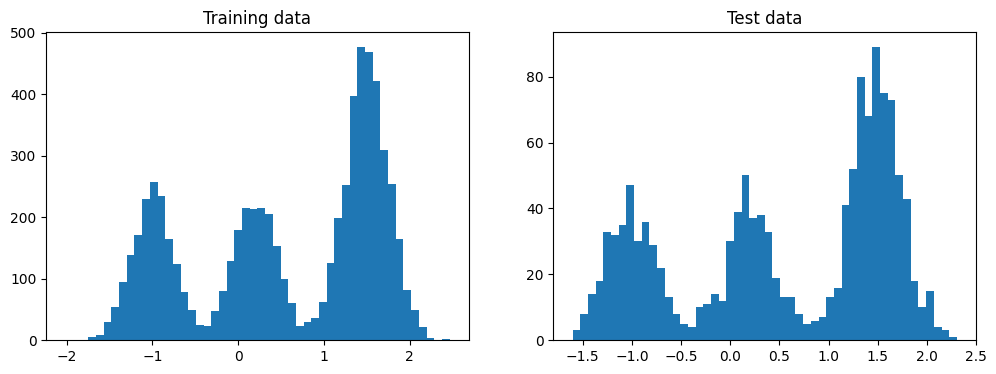

In [30]:
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].hist(train_loader.dataset.array, bins=50)
_ = axes[1].hist(test_loader.dataset.array, bins=50)
_ = axes[0].set_title('Training data')
_ = axes[1].set_title('Test data')

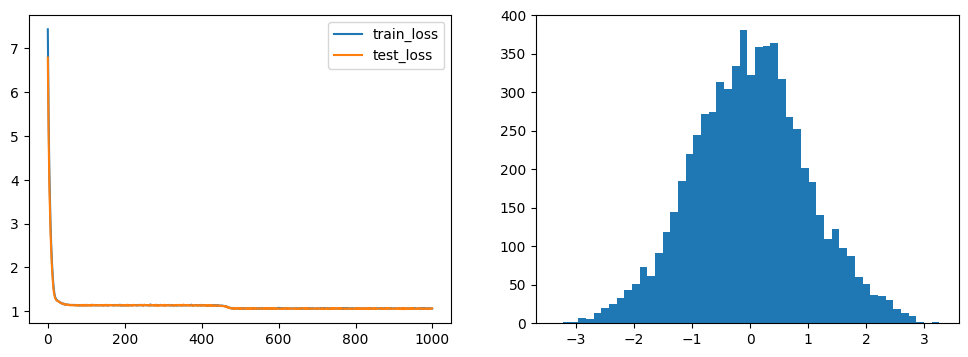

In [35]:
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].plot(train_losses, label='train_loss')
_ = axes[0].plot(test_losses, label='test_loss')
axes[0].legend()

with torch.no_grad():
    z, _ = flow(torch.FloatTensor(train_loader.dataset.array))
    

_ = axes[1].hist(np.array(z), bins=50)

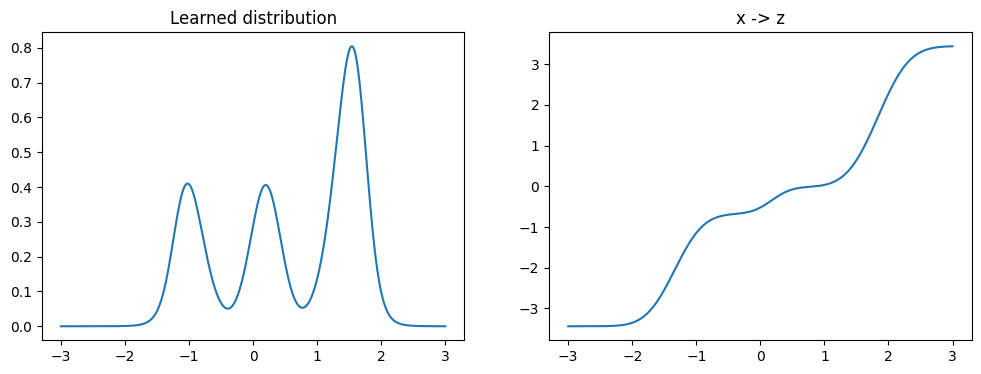

In [32]:
x = np.linspace(-3,3,1000)
with torch.no_grad():
    z, dz_by_dx = flow(torch.FloatTensor(x))
    px = (target_distribution.log_prob(z) + dz_by_dx.log()).exp().cpu().numpy()
    
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].plot(x,px)
_ = axes[0].set_title('Learned distribution')

_ = axes[1].plot(x,z)
_ = axes[1].set_title('x -> z')